## Vector Autoregression

In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplolib', 'inline')
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.3f}'.format

plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

In [3]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

In [4]:
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')

ans.head()

,ano,cd_ops,trimestre,receita,despesa,benef,modalidade,port_ops,contratacao
0,2018,303976,2018Q1,29314392.257,23298026.978,27209,Cooperativa Médica,Grande,Adesao
1,2018,342084,2018Q1,100884002.783,71227129.017,50901,Cooperativa Médica,Grande,Adesao
2,2018,348295,2018Q2,4388045.611,4255788.457,6692,Cooperativa Médica,Grande,Adesao
3,2018,348295,2018Q3,4596013.001,4967336.847,6736,Cooperativa Médica,Grande,Adesao
4,2018,348295,2018Q4,4842097.207,3878879.670,7581,Cooperativa Médica,Grande,Adesao


In [25]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['ano'] = ans_agrup['trimestre'].str[:4]

ans_agrup['ano'] = ans_agrup['ano'].astype('int')

ans_agrup['n_tri'] = ans_agrup['trimestre'].str[-1:]

ans_agrup['n_tri'] = ans_agrup['n_tri'].astype('int')

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

ans_agrup['receita_l1'] =  ans_agrup['receita'].shift(1)

ans_agrup['receita_l2'] =  ans_agrup['receita'].shift(2)  

ans_agrup.set_index('trimestre', inplace=True)

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,receita_l1,receita_l2
trimestre,,,,,,,,,
2018Q1,2.150,1.580,1655264,38,73.490,2018,1,NaN,NaN
2018Q2,2.160,1.640,1667369,38,75.930,2018,2,2.150,NaN
2018Q3,2.290,1.850,1678692,38,80.790,2018,3,2.160,2.150
2018Q4,2.380,1.250,1693379,38,52.520,2018,4,2.290,2.160
2019Q1,2.370,1.870,1700602,38,78.900,2019,1,2.380,2.290
2019Q2,2.460,1.980,1730500,38,80.490,2019,2,2.370,2.380
2019Q3,2.550,1.950,1733529,38,76.470,2019,3,2.460,2.370
2019Q4,2.650,2.080,1757501,38,78.490,2019,4,2.550,2.460
2020Q1,2.750,2.100,1876410,39,76.360,2020,1,2.650,2.550


In [24]:
columns = ['receita','despesa']

ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2018Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   receita      16 non-null     float64
 1   despesa      16 non-null     float64
 2   benef        16 non-null     int32  
 3   n_ops        16 non-null     int32  
 4   pct_despesa  16 non-null     float64
 5   ano          16 non-null     int32  
 6   n_tri        16 non-null     int32  
dtypes: float64(3), int32(4)
memory usage: 768.0 bytes


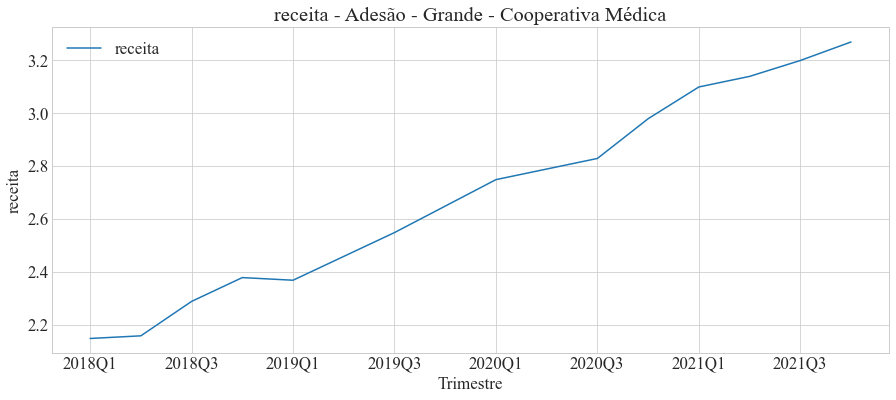

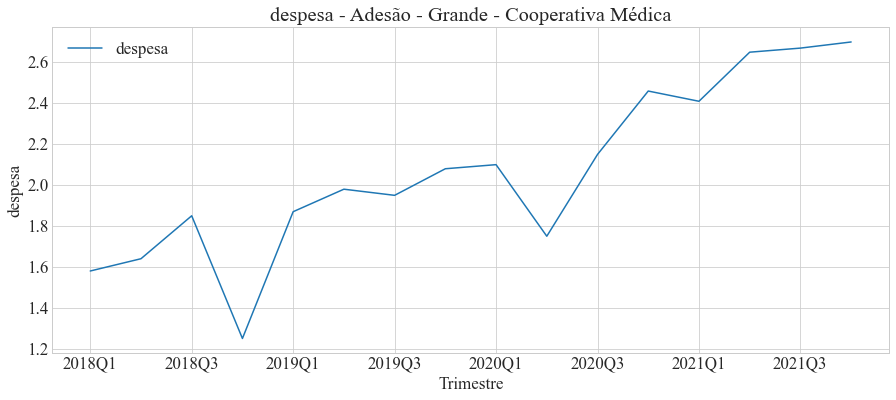

In [52]:
for c in ans_agrup[columns]:
    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
    
    print(f'Mean Squared Error (MSE) is : {metrics.mean_squared_error(y_true,y_pred)}')

    print(f'Mean Absolute Error (MAE) is : {metrics.mean_absolute_error(y_true,y_pred)}')

    print(f'Root Mean Squared Error (MAE) is : {np.sqrt(metrics.mean_squared_error(y_true,y_pred))}')

    print(f'Coefficient of determination R^2 is : {metrics.r2_score(y_true,y_pred)}', end = '\n\n')

    return


def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')

In [26]:
#Create X and y object
ans_agrup = ans_agrup.dropna()
X = ans_agrup[['ano','n_tri']]
y = ans_agrup['receita']

# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1875, random_state=1234, shuffle=False)

from sklearn.ensemble import RandomForestRegressor

my_rf = RandomForestRegressor()

In [27]:
my_rf.fit(X_train,y_train)
fcst = my_rf.predict(X_test)

from sklearn.metrics import r2_score
r2_score(list(y_test),list(fcst))

-19.768138976377987

In [29]:
from sklearn.model_selection import GridSearchCV

my_rf = GridSearchCV(RandomForestRegressor(),
                     {'max_features':[0.65,0.7,0.75,0.8,0.85,0.9,0.95],
                      'n_estimators':[10,50,100,250,500,750,1000]}, scoring='r2', n_jobs=-1)

my_rf.fit(X_train,y_train)
fcst = my_rf.predict(X_test)
r2_score(list(y_test),list(fcst))

-20.90496062992124